# model trainning

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [3]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

In [4]:
print(X_train.shape, X_test.shape)
print(np.bincount(y_train))

(246008, 102) (61503, 102)
[226148  19860]


## logistic regression

In [6]:
log_model = LogisticRegression(max_iter=2000,
                               class_weight="balanced",
                               n_jobs=-1)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)
log_proba = log_model.predict_proba(X_test)[:, 1]


## random forest classifier

In [20]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced",  # important for imbalance
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

rf_pred  = rf_clf.predict(X_test)
rf_proba = rf_clf.predict_proba(X_test)[:, 1]

## XGBoost

In [12]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos = neg / pos
print("neg:", neg, "pos:", pos, "scale_pos_weight:", scale_pos)


neg: 226148 pos: 19860 scale_pos_weight: 11.38710976837865


In [13]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    objective="binary:logistic",
    scale_pos_weight=scale_pos , ####
    tree_method="hist"
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]


## lightGBM

In [14]:
lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    scale_pos_weight=scale_pos,   ##
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8455
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


## evaluation function

In [15]:
def evaluate_model(name, y_test, y_pred, y_proba):
    print(f"\n====== {name} ======")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("ROC AUC  :", roc_auc_score(y_test, y_proba))


## evaluation de toutes les modéles

In [21]:
evaluate_model("Logistic Regression", y_test, log_pred, log_proba)
evaluate_model("XGBoost", y_test, xgb_pred, xgb_proba)
evaluate_model("LightGBM", y_test, lgbm_pred, lgbm_proba)
evaluate_model("Random Forest",y_test, rf_pred, rf_proba)




====== Logistic Regression ======
Accuracy : 0.6074012649789441
Precision: 0.11783223749750947
Recall   : 0.5955689828801611
F1 Score : 0.19673985362608118
ROC AUC  : 0.6368476644516853

====== XGBoost ======
Accuracy : 0.7230704193291384
Precision: 0.17395298567954606
Recall   : 0.6483383685800604
F1 Score : 0.2743076267575629
ROC AUC  : 0.7596788346541392

====== LightGBM ======
Accuracy : 0.7069736435621027
Precision: 0.1696270431658317
Recall   : 0.6751258811681773
F1 Score : 0.27113160236188627
ROC AUC  : 0.7596846644898383

====== Random Forest ======
Accuracy : 0.9193210087312814
Precision: 0.5517241379310345
Recall   : 0.0032225579053373615
F1 Score : 0.006407689227072487
ROC AUC  : 0.7344583954389846


## plot ROC curves 

In [24]:
import matplotlib.pyplot as plt


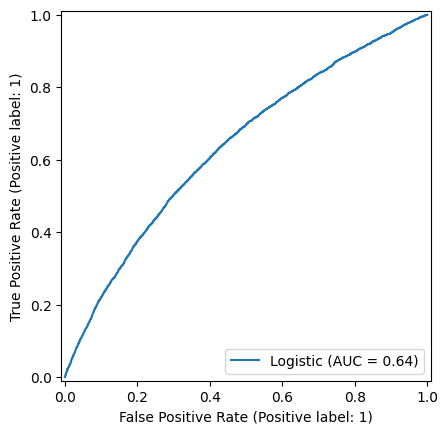

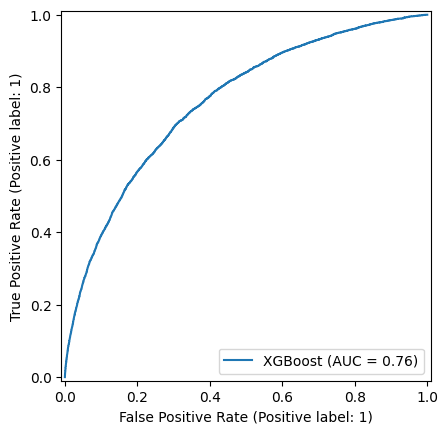

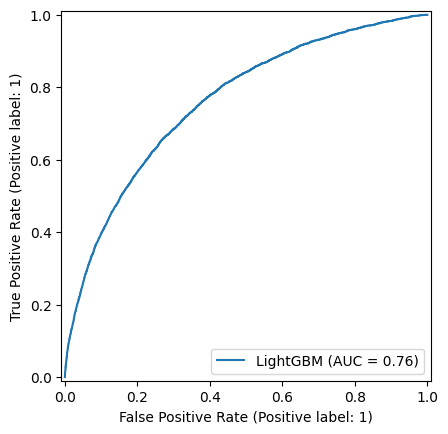

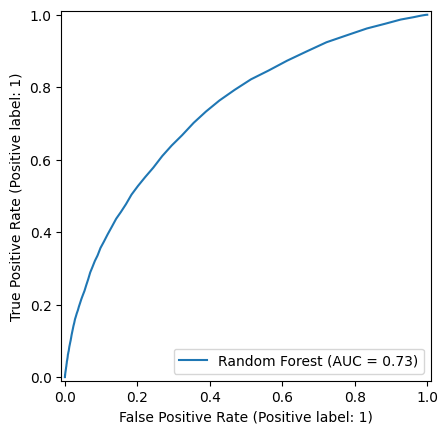

In [28]:
RocCurveDisplay.from_predictions(y_test, log_proba, name="Logistic")
RocCurveDisplay.from_predictions(y_test, xgb_proba, name="XGBoost")
RocCurveDisplay.from_predictions(y_test, lgbm_proba, name="LightGBM")

RocCurveDisplay.from_predictions(y_test, rf_proba,   name="Random Forest")
plt.show()


- ### ROC AUC  is the metric here because the data is unbalanced ===> a tie between lightGBM and XGBoost
- ### however  i chose lightGBM since it is lighter ,faster, better at production performance , more used in industry and more resource efficient .


## feature importance (LightGBM)

In [30]:
importances = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(20)


EXT_SOURCE_3                    586
EXT_SOURCE_1                    575
YEARS_BIRTH                     566
AMT_CREDIT                      511
EXT_SOURCE_2                    490
AMT_ANNUITY                     474
DAYS_EMPLOYED                   432
AMT_GOODS_PRICE                 382
DAYS_LAST_PHONE_CHANGE          351
DAYS_REGISTRATION               296
AMT_INCOME_TOTAL                272
REGION_POPULATION_RELATIVE      200
ORGANIZATION_TYPE               158
HOUR_APPR_PROCESS_START         127
AMT_REQ_CREDIT_BUREAU_YEAR      119
CODE_GENDER                     116
OCCUPATION_TYPE                 112
TOTALAREA_MODE                  105
NAME_FAMILY_STATUS              104
YEARS_BEGINEXPLUATATION_MODE    103
dtype: int32

## save the best model

In [31]:
importances = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(20)


EXT_SOURCE_3                    586
EXT_SOURCE_1                    575
YEARS_BIRTH                     566
AMT_CREDIT                      511
EXT_SOURCE_2                    490
AMT_ANNUITY                     474
DAYS_EMPLOYED                   432
AMT_GOODS_PRICE                 382
DAYS_LAST_PHONE_CHANGE          351
DAYS_REGISTRATION               296
AMT_INCOME_TOTAL                272
REGION_POPULATION_RELATIVE      200
ORGANIZATION_TYPE               158
HOUR_APPR_PROCESS_START         127
AMT_REQ_CREDIT_BUREAU_YEAR      119
CODE_GENDER                     116
OCCUPATION_TYPE                 112
TOTALAREA_MODE                  105
NAME_FAMILY_STATUS              104
YEARS_BEGINEXPLUATATION_MODE    103
dtype: int32